In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [86]:
import glob
from astropy.io import fits

In [3]:
figsize(8,6)

In [4]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [5]:
banks = ['A', 'B', 'C', 'D']

In [6]:
# 5 has two
# 2 has one
# 3 has one

In [7]:
def get_data(bank='A', session='5'):
    fnames = glob.glob('/data2/GBT/S140/Daisy/*/*_0'+session+'_*'+bank+'*.rfireduced_new.npz')
    fnames.sort()
    
    calibrations = np.load('/home/mabitbol/GBT-S140/calibrations/calibration_3C295_0'+session+'_'+bank+'.npy').item()
    fdiode = calibrations['freqs']
    pdiode = calibrations['pdiode']
    if session == 5:
        pdiode1 = calibrations['pdiode1']
        pdiode = 0.5 * (pdiode + pdiode1)

    for k, fname in enumerate(fnames):
        nz = np.load(fname)
        ra = nz['sra']
        dec = nz['sdec']
        mask = nz['valid']
        az = nz['AZIMUTH'][::8]
        el = nz['ELEVATIO'][::8]
        freqs = nz['freqs']
            
        gain = pdiode / ( nz['xxon'] - nz['xxoff'])
        calibd = nz['xxoff'] * gain
        
        mask[:200] = False
        mask[400:] = False
    
        calibd = calibd[:, mask]

        if k == 0:
            calibrated = calibd
            ras = ra
            decs = dec
            els = el
        else: 
            try: 
                calibrated = np.concatenate([calibrated, calibd])
                ras = np.concatenate([ras, ra])
                decs = np.concatenate([decs, dec])
                els = np.concatenate([els, el])
            except:
                print fname
                                        
    return calibrated, ras, decs, els

In [19]:
calibrated, ras, decs, els = get_data('A', '5')

/data2/GBT/S140/Daisy/scan_05_014.raw.vegas/scan_05_014.raw.vegas.A.fits.rfireduced_new.npz


In [20]:
tmark = 5 * 60 * 25

In [33]:
c0 = calibrated[:, 1]
tmask = ~np.isnan(c0)
c0 = c0[tmask]
sras = ras[tmask][: (len(c0)/tmark) * tmark]
sdecs = decs[tmask][: (len(c0)/tmark) * tmark]
c0 = c0[: (len(c0)/tmark) * tmark]

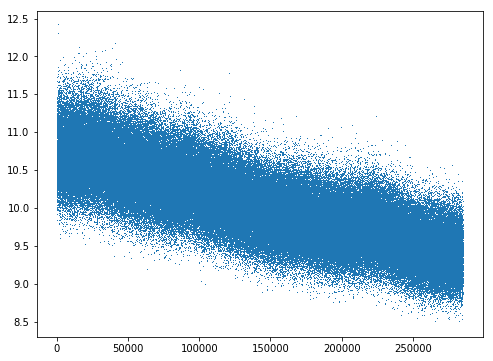

In [34]:
plot(c0, ',')
#xlim(0, tmark * 20)

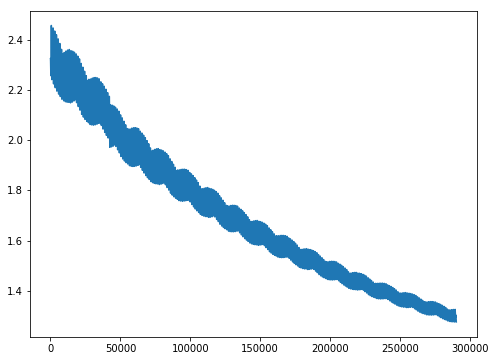

In [35]:
plot(1./np.sin(els*pi/180.))

In [36]:
movingstd = c0.reshape(tmark, -1).std(0)
scal = c0.reshape(tmark, -1)
scal -= scal.mean(0)
N = scal.shape[-1]

In [37]:
cov = np.zeros([N, N])
for k in range(N):
    for i in range(N):
        cov[i, k] = np.mean(scal[:, i] * scal[:, k])
cov = np.array(np.mat(cov).I)

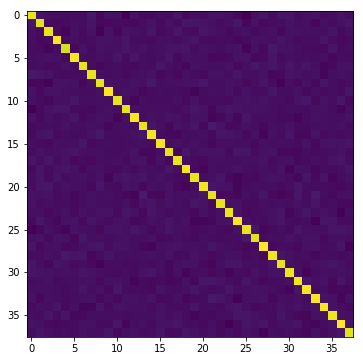

In [38]:
imshow(cov)

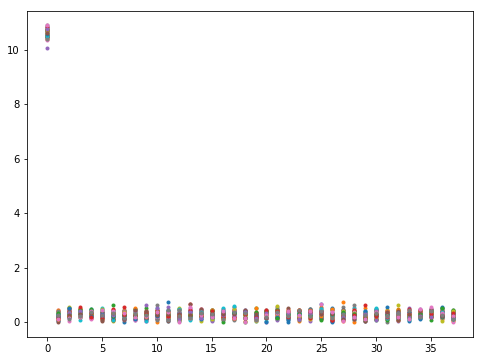

In [39]:
for k in range(N):
    plot(np.abs(np.roll(cov[k, :], -k)), '.')

In [40]:
np.std(np.diag(cov)) / np.mean(np.diag(cov)) * 100

1.583679017177773

In [41]:
bank = 'B'
if bank == 'A':
    cfreq = 4.575
elif bank == 'B':
    cfreq = 5.625
elif bank == 'C':
    cfreq = 6.125
elif bank == 'D':
    cfreq = 7.175
beam = 12.6 / cfreq

In [42]:
pixbeam = 1. 
beamarea = np.pi / (4. * np.log(2)) * beam**2
pixelarea = pixbeam**2
units = pixelarea / beamarea
nrapix = int((sras.max() - sras.min()) / (pixbeam / 60.))
ndecpix = int((sdecs.max() - sdecs.min()) / (pixbeam / 60.))

In [43]:
datamap, hits, rabins, decbins = naive_map(c0, sras, sdecs, nrapix, ndecpix)

In [44]:
mask = hits == 0 
signal = np.zeros_like(datamap)
signal[~mask] = datamap[~mask] / hits[~mask] * units
signal[mask] = np.nan

In [45]:
signal.shape

(167, 401)

/usr/lib64/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


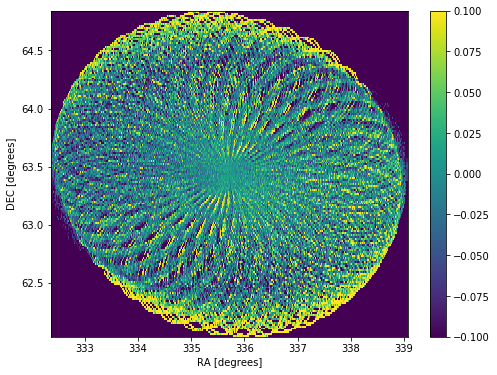

In [46]:
figure()
pc = pcolormesh(rabins, decbins, signal)
#clim(1.35, 1.45)
cb = colorbar()
xlabel('RA [degrees]')
ylabel('DEC [degrees]')

In [47]:
len(sras)

285000

In [48]:
len(c0)

285000

In [76]:
rc0 = c0.reshape(-1, tmark)

In [77]:
c0

array([ 0.85360468,  0.16019721,  1.06226384, ..., -1.04597203,
       -0.75998443, -0.52118184])

In [78]:
rc0

array([[ 0.85360468,  0.16019721,  1.06226384, ...,  0.56724966,
         0.29026673,  0.40847805],
       [ 0.20519698,  0.36040772,  0.37842903, ...,  0.80653023,
         0.95429332,  0.01607845],
       [ 0.67894377,  0.57194803,  0.24874381, ...,  0.03461647,
         0.32177603,  0.41411427],
       ..., 
       [-0.84502425, -0.84943352, -0.53514524, ..., -0.37071019,
        -0.0528929 , -0.94986749],
       [-0.54509986, -0.65169767, -1.03242701, ..., -0.72543336,
        -0.67632388, -0.72395132],
       [-0.60787662, -0.59173677, -0.52778382, ..., -1.04597203,
        -0.75998443, -0.52118184]])

In [79]:
rc0.shape

(38, 7500)

In [80]:
cov.shape

(38, 38)

In [83]:
rc0[:, 1]

array([ 0.16019721,  0.36040772,  0.57194803,  0.76552811,  0.75785581,
        0.99482834,  0.58495713,  0.45680286,  0.72578424, -0.08356777,
       -0.20414053,  0.48930706,  0.35534975, -0.20166305,  0.20331617,
        0.75638847,  0.29702343,  0.33370324,  0.38579268,  0.0029707 ,
       -0.52807187,  0.21406379, -0.56888997, -0.37126491,  0.26385875,
       -0.31995783, -0.41658883, -0.16264062,  0.10692486, -0.13246848,
        0.10319366,  0.03137982, -0.7647447 , -0.68841406, -0.46809124,
       -0.84943352, -0.65169767, -0.59173677])

In [84]:
RHS = np.zeros_like(c0)
for k in range(len(c0)):
    i = k / tmark
    j = k % tmark
    RHS[k] = np.sum( cov[i, :] * rc0[:, j])

In [7]:
def savetod(bank='A', session=5):
    calibrated, ras, decs = get_data(bank, session)
    
    tmask = np.ones(len(calibrated), dtype=bool)
    ts = np.arange(len(calibrated))
    if session == 5:
        tmask = (ts < 42000) | (ts > 50000 )
    if session == 3:
        if bank == 'A':
            tmask[(ts > 35000) * (ts < 50000 )] = False
            tmask[(ts > 162500)] = False
        if bank == 'B':
            tmask[(ts > 62000) * (ts < 72000 )] = False
            tmask[(ts > 120000) * (ts < 128000 )] = False
        else:
            tmask[(ts > 38000) * (ts < 39000 )] = False
    
    return 
